In [98]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Goal: Run statistical analysis for single cell data

Steps

1. read single cell data and only read in specific genes (columns) specified in external spreadsheet

2. apply statistical tests on a column by column basis for all genes for tumor vs ductal cells

    * chi sq test for counts of zeros
    * t test for raw data (sample means) - one tail = tumor > ductal
    * fisher exact test for count of zeros

## Outputs
    * tumor_ductal_statistical_testing.csv (statistical test results for genes)

In [145]:
rows = pd.read_csv('data/rows for X.csv',header = None)

row_index = list(rows[0])

row_index = [val.lower() for val in row_index]

headers = pd.read_csv('data/columns for X.csv', header = None)

genes_to_keep = pd.read_csv('data/neurotransmitter genes 101020.csv', header = None)

genes_to_keep = list(genes_to_keep[0])

column_names = list(headers[0])

df_raw = pd.read_csv('data/X.csv',names = column_names, usecols = genes_to_keep)

df_raw.shape

Text(0.5, 1.0, 'percentage of 0s in columns - 153 subset of genes')

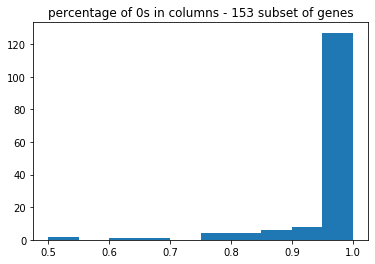

In [129]:
plt.hist((df_raw == 0).sum()/df_raw.shape[0])
plt.title('percentage of 0s in columns - 153 subset of genes')

In [130]:
df_raw.shape

(88031, 153)

In [131]:
df_raw.index = row_index
df_raw.reset_index(inplace=True)

In [132]:
df_raw = df_raw.rename({'index':'row_id'}, axis = 1)

In [155]:
df_raw.to_csv('data/unscaled_downselected_genes.csv',index = False)

In [141]:
df_tumor_ductal = df_raw[(df_raw['row_id'] == 'tumor') | (df_raw['row_id'] == 'ductal')]

In [147]:
((df_tumor_ductal == 0).sum()/df_tumor_ductal.shape[0]).head()

row_id    0.000000
GABRD     0.997899
HTR6      0.999148
HTR1D     0.996431
GRIK3     0.994370
dtype: float64

In [213]:
from scipy.stats import ttest_ind
def t_test(x,y,alternative='both-sided'):
    _, double_p = ttest_ind(x,y,equal_var = False)
    if alternative == 'both-sided':
        pval = double_p
    elif alternative == 'greater':
        if np.mean(x) > np.mean(y):
            pval = double_p/2.
        else:
            pval = 1.0 - double_p/2.
    elif alternative == 'less':
        if np.mean(x) < np.mean(y):
            pval = double_p/2.
        else:
            pval = 1.0 - double_p/2.
    return pval

In [182]:
from scipy.stats import ttest_ind, chi2_contingency, fisher_exact

In [214]:
gene_list = []
ttest_pvalue_list = []
chisq_pvalue_list = []
fisher_pvalue_list = []
more_counts_list = []
for gene in genes_to_keep:
    tumor_values = df_tumor_ductal[df_tumor_ductal['row_id'] == 'tumor'][gene]
    ductal_values = df_tumor_ductal[df_tumor_ductal['row_id'] == 'ductal'][gene]
    
    ttest_pvalue = t_test(tumor_values, ductal_values, alternative = 'greater')
    
    tumor_zero_count = np.sum(tumor_values ==0) 
    tumor_nonzero_count = np.sum(tumor_values !=0) 
    
    ductal_zero_count = np.sum(ductal_values ==0) 
    ductal_nonzero_count = np.sum(ductal_values !=0) 
    
    contingency = [[tumor_zero_count,ductal_zero_count],
              [tumor_nonzero_count,ductal_nonzero_count]]

    if (ductal_nonzero_count == 0) and (tumor_nonzero_count == 0):
    
        chisq_pvalue = 'n/a - all values are zero'
        fisher_pvalue = 'n/a - all values are zero'

    else:
        _, chisq_pvalue, _,_ = chi2_contingency(contingency)
        _, fisher_pvalue = fisher_exact(contingency)

    if tumor_nonzero_count/tumor_zero_count > ductal_nonzero_count/ductal_zero_count:
        more_counts_list.append('tumor')
    else:
        more_counts_list.append('ductal')
        
    gene_list.append(gene)
    ttest_pvalue_list.append(ttest_pvalue)
    chisq_pvalue_list.append(chisq_pvalue)
    fisher_pvalue_list.append(fisher_pvalue)

In [215]:
df_test_results = pd.DataFrame(
{
    'gene': gene_list,
    'ttest_pvalue': ttest_pvalue_list,
    'chisq_pvalue':chisq_pvalue_list,
    'fisher_pvalue':fisher_pvalue_list,
    'greater_pct_nonzero':more_counts_list
}
)

In [217]:
df_test_results.to_csv('data/tumor_ductal_statistical_testing.csv',index=False)

# Scaling and downselection of tumor only genes

In [138]:
df_raw_tumor = df_raw[df_raw['row_id'] == 'tumor']

df_raw_tumor.to_csv('data/unscaled_tumor_downselected_genes.csv',index = False)

df_neurotrans_group = pd.read_csv('data/neurotransmitter_groups.csv')

df_neurotrans_group.head()

In [140]:
unique_neurotransmitters = df_neurotrans_group['Neurotransmitter Ligand'].unique()
unique_neurotransmitters

df_list = []
for neurotrans, df_neurotrans in df_neurotrans_group.groupby('Neurotransmitter Ligand'):
    gene_list = list(df_neurotrans['Genes'].unique())
    gene_list = [gene for gene in gene_list if gene in df_raw.columns]
    
    df_raw_subset = df_raw_tumor[gene_list]
    array_raw_subset = np.array(df_raw_subset)
    value_90th_percentile = np.percentile(array_raw_subset, q = 90)
    print(value_90th_percentile)
    